## Exercise 7.3

In [36]:
import time
import matplotlib.pyplot as plt
import random

In [2]:
# possibility for symbols and operators
SYMBOL = ['F','P','Q','X','Y']

In [3]:
'''
for 7.3 (a):
 reference1 : https://github.com/aimacode/aima-python/blob/master/utils.py
 reference2 : https://github.com/aimacode/aima-python/blob/master/logic.py
'''

class PL_expr(object):
    """A mathematical expression with an operator and 0 or more arguments.
    op is a str in OPERTOR; args are Expressions.
    Expr('x') or Symbol('x') creates a symbol (a nullary Expr).
    Expr('~', x) creates a unary; Expr('&', x, 1) creates a binary."""
    def __init__(self, op, *args):
        self.op = str(op)
        self.args = args
        
    # Operator overloads
    def __invert__(self):   return PL_expr('~', self)
    
    def __and__(self, rhs): return PL_expr('&', self, rhs)
    def __rand__(self, lhs): return PL_expr('&',  lhs, self)
    
    def __or__(self, rhs):
        "Allow both P | Q, and P |'==>'| Q."
        if isinstance(rhs, PL_expr):
            return PL_expr('|', self, rhs)
        else:
            return PartialExpr(rhs, self)
    
    def __ror__(self, lhs):  return PL_expr('|',  lhs, self)
    
    def __repr__(self):
        op = self.op
        args = [str(arg) for arg in self.args]
        if op is not None:       # f(x) or f(x, y)
            return '{}({})'.format(op, ', '.join(args)) if args else op
        elif len(args) == 1:        # -x or -(x + 1)
            return op + args[0]
        else:                       # (x - y)
            opp = (' ' + op + ' ')
            return '(' + opp.join(args) + ')'
    

class PartialExpr:
    """Given 'P |'==>'| Q, first form PartialExpr('==>', P), then combine with Q."""
    def __init__(self, op, lhs): self.op, self.lhs = op, lhs
    def __or__(self, rhs):       return PL_expr(self.op, self.lhs, rhs)
    def __repr__(self):          return "PartialExpr('{}', {})".format(self.op, self.lhs)
    
    

infix_ops = '==> <== <=>'.split()


def expr_handle_infix_ops(x):
    """Given a str, return a new str with ==> replaced by |'==>'|, etc.
    >>> expr_handle_infix_ops('P ==> Q')
    "P |'==>'| Q"
    """
    for op in infix_ops:
        x = x.replace(op, '|' + repr(op) + '|')
    return x    

In [4]:
def Symbol(name):
    "A Symbol is just an Expr with no args."
    return PL_expr(name)


def symbols(names):
    "Return a tuple of Symbols; names is a comma/whitespace delimited str."
    return tuple(Symbol(name) for name in names.replace(',', ' ').split())

In [5]:
def pl_true(exp, model={}):
    """
    Return True if the propositional logic expression is true in the model,
    and False if it is false. 
    The model only give true value for every proposition.
    """
    if exp in [True, False]:
        return exp
    
    op, args = exp.op, exp.args
    
    
    if op in SYMBOL:
        return model.get(exp)
    elif op == '~':
        p = pl_true(args[0], model)
        if p is None:
            return None
        else:
            return not p
    elif op == '|':
        result = False
        for arg in args:
            p = pl_true(arg, model)
            if p is True:
                return True
            if p is None:
                result = None
        return result
    elif op == '&':
        result = True
        for arg in args:
            p = pl_true(arg, model)
            if p is False:
                return False
            if p is None:
                result = None
        return result
    
    p, q = args
    
    if op == '==>':
        return pl_true(~p | q, model)
    
    pt = pl_true(p, model)
    if pt is None:
        return None
    qt = pl_true(q, model)
    if qt is None:
        return None
    if op == '<=>':
        return pt == qt
    else:
        raise ValueError("illegal operator in logic expression" + str(exp))

In [6]:
(X, Y, P, Q, F) = symbols('X, Y, P, Q, F')

In [7]:
'''
for 7.3 (a):
    test algorithm
'''
exp1 = ~(P & Q)  |'==>'|  (~P | ~Q)
exp2 = P | Q
exp3 = ~(~P)
exp4 = (P | Q) | ~X

print pl_true(exp1, model={P:True, Q:True})
print pl_true(exp2, model={P:True, Q:True})
print pl_true(exp3, model={P:True, Q:True})
print pl_true(exp4, model={P:True, Q:True, X:True})

True
True
True
True


In [116]:
'''
for 7.3 (a):
    plot for linearity
    random generate length length 0 to 15 sentences, each generate 10000 times
    roughly, use random operation 1 time add sentence size 1
'''
f_invert = lambda single_expr : ~single_expr
f_and = lambda exp1, single_expr: exp1 & single_expr
f_or = lambda exp1, single_expr: exp1 | single_expr
f_imply = lambda exp1, single_expr: exp1 |'==>'| single_expr
f_equal = lambda exp1, single_expr: exp1 |'<=>'| single_expr

def random_sentence():
    list_lengths = [_ for _ in range(1,21)]
    aver_time = []
    for single_len in list_lengths:
        sam_len30 = gen_30el(single_len)
        aver_time.append(make_time_list(sam_len30))
    return aver_time

def gen_30el(length):
    sam_len30 = []
    for _ in range(10000):
        sam_len30.append(random_specific_len_sentence(length))
    return sam_len30

def random_specific_len_sentence(length):
    single_expr = P
    if length == 1:
        return single_expr
    else:
        for _ in range(length):
            ran_op = random.choice(range(0,5))
            if ran_op == 0:
                single_expr = f_invert(single_expr)
            else:
                exp1 = random.choice([X, Y, P, Q, F])
                if ran_op ==1:
                    single_expr = f_and(exp1,single_expr)
                elif ran_op ==2:
                    single_expr = f_or(exp1,single_expr)
                elif ran_op ==3:
                    single_expr = f_imply(exp1,single_expr)
                elif ran_op == 4 :
                    single_expr = f_equal(exp1,single_expr)

    return single_expr

def make_time_list(lst):
    time_list = []
    for el in lst:
        (X, Y, P, Q, F) = symbols('X, Y, P, Q, F')
        time0 = time.time()
        pl_true(el, model={X: True, Y: True, P:True, Q:True, F:True })
        time_list.append(time.time() - time0)
        aver_time = sum(time_list)/float(len(time_list))
    return aver_time

In [123]:
list_lengths = [_ for _ in range(1,21)]
time_list = random_sentence()

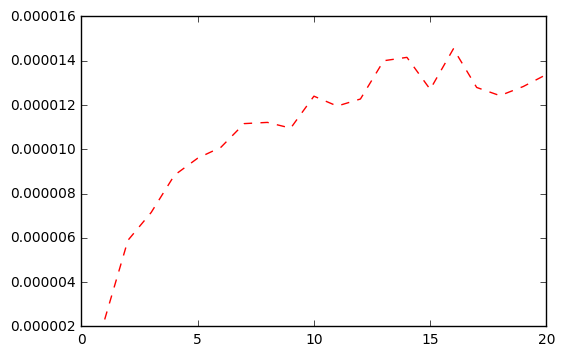

In [124]:
plt.plot(list_lengths, time_list, 'r--')
plt.show()

In [118]:
'''
for 7.3 (b):
    Exp1:pl_true(True, model={})
    Exp2:pl_true(False, model={})
    Exp3:pl_true(True | P , model={})
'''
print pl_true(True, model={})
print pl_true(False, model={})
print pl_true(True | P , model={})

True
False
True


In [9]:
'''
for 7.3 (c):
    In the example below, it will always be true, but the model will not decide true
    Exp1:pl_true(P | ~P, model={})
    Exp2:pl_true(~(P & ~P), model={})
'''
P = Symbol(P)
print pl_true(P | ~P, model={})
print pl_true(~(P & ~P), model={})

None
None


In [10]:
'''
for 7.3 (d):
    If model is not set, then set it to False
'''

def pl_true_modify(exp, model={}):

    if exp in [True, False]:
        return exp
    
    op, args = exp.op, exp.args
    
    
    if op in SYMBOL:
        return model.get(exp)
    elif op == '~':
        p = pl_true(args[0], model)
        if p is None:
            return False
        else:
            return not p
    elif op == '|':
        result = False
        for arg in args:
            p = pl_true(arg, model)
            if p is True:
                return True
            if p is None:
                result = None
        return result
    elif op == '&':
        result = True
        for arg in args:
            p = pl_true(arg, model)
            if p is False:
                return False
            if p is None:
                result = True
        return result
    
    p, q = args
    
    if op == '==>':
        return pl_true(~p | q, model)
    
    pt = pl_true(p, model)
    if pt is None:
        return False
    
    qt = pl_true(q, model)
    if qt is None:
        return False
    
    if op == '<=>':
        return pt == qt
#     elif op == '^':  # xor or 'not equivalent'
#         return pt != qt
    else:
        raise ValueError("illegal operator in logic expression" + str(exp))

In [11]:
'''
for 7.3 (d):
    Same example as 7.3 (c), it will always be true, and the model will decide true
    what can be detect after modification:
        Exp1:pl_true_modify(P & ~P, model={})
    what can not be detect:
        Exp1:pl_true_modify(P | ~P, model={})
        Exp2:pl_true_modify(~P | P, model={})
        Exp3:pl_true_modify(~P | (P & Q) | ~P, model={})
'''
P = Symbol(P)
print pl_true_modify(P & ~P, model={})
print pl_true_modify(P | ~P, model={})
print pl_true_modify(~P | P, model={})
print pl_true_modify(~P | (P & Q) | P, model={})

True
None
None
None


In [12]:
'''
for 7.3 (e):
    Yes.
    Because in many cases involving the | and & operators, 
    the value of the truth assignment can be returned without
    needing to evaluate both sides of the operator.
'''

'\nfor 7.3 (e):\n    Yes.\n    because in many cases involving the | and & operators, \n    the value of the truth assignment can be returned without\n    needing to evaluate both sides of the operator.\n'